# Project - Food symphony 🥙
 <p><div class="lev1"><a href="#1/-Introduction-of-the-structure"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Introduction of the structure</a></div>
  <div class="lev3"><a href="#2/-Preprocessing-the-ingredients-data-(Missing-values,-upper-cases,-natural-language-processing)"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Preprocessing the ingredients data (Missing values, upper cases, natural language processing)</a></div>
  <div class="lev3"><a href="#3/-Co-occurences-and-Covariance"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Co-occurences and Covariance</a></div>
  <div class="lev3"><a href="#4/-Linear-Regression"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Linear Regression</a></div>
  <div class="lev3"><a href="#5/-Compute-new-special-recipes"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Compute new special recipes</a></div>

## 1/ Introduction of the structure
First of all, in this section, we remind and describe in detail the overall structure of the our project: the steps and the goals.

The diagram below gives an illustrated overview:

<img src="Structure.jpeg" width=900>

The diagram illustrates the work we have been doing until now for the food symphony project. The first part consists in filtering the raw data in order to get a clean data set where we could do some analysis and perform machine learning algorithms on it.

The most important step in the first part of the project  and the most time consuming  was to design filters that enable us to get a proper data set to analyse. Indeed, we had to deal with a lot of different typos containing valid information. Instead of skipping data,  we did our best to drag out all the available information.

The first filtering step was to deal with special characters and filter useless parenthesis. After this first filtering step, we decided to create 3 lists (cf list_creation.py) in order to select in the recepies the information about unit, ingredients and the technics to apply for each ingredient. The ingredients that didn’t have a valid name were not taken into account, the ones with a quantity 'x' but no valid unit were added as 'x unit'. 
The unit list, was created by hand, by checking information in Wikipedia. The techniques list was done by using the raw data, and taking all the verbs in the past tense. The ingredients list was create by web scraping. 

Once the filtering is done, we create a data frame with the ingredients as columns and the recipes as rows.
 We create the co-occurrence matrix and the covariance matrix to make a first analysis, and we will use them in order to create new recipes.
 
Additionally, we generate a data frame containing unit weight by ingredient. This dataset will be very helpful to improve our current results in the prediction of nutrients information such as the recipe calories or cholesterol contempt, while using linear regression models.




## Initializing data

In [1]:
# ----- Librairies ----- #
import pandas as pd
import re
import sys
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.tag import UnigramTagger
from nltk.corpus import brown
import webcolors
from IPython.display import display
import random
from random import randint
import time
import emoji
import json


import tensorflow as tf
from keras import regularizers
from keras.constraints import maxnorm, nonneg
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import optimizers
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors
from serving_scraping import *
from str_functions import *
from pre_process import *
import matplotlib.pyplot as plt
import math

from __future__ import print_function

# ----- Loading the dataset'recipeInfo_WestWhiteHorvitz_WWW2013.csv' ----- #
data_file='recipeInfo_WestWhiteHorvitz_WWW2013_modified.csv'
raw_data = pd.read_csv(data_file ,sep=';')

/Users/jonathan/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


### Vizualizing nutrients data 
Extract the nutrients from the dataset which will be used it the regression model in order to predict the nutrients informations from the dataset using machine learning models.

In [2]:
nutri_data=raw_data[['title','ingredients_list','kcal_total','kcal_carb','kcal_fat','kcal_protein','mg_sodium','mg_cholesterol']].copy()
nutri_data.head(5)

,title,ingredients_list,kcal_total,kcal_carb,kcal_fat,kcal_protein,mg_sodium,mg_cholesterol
0,Easy Light Chocolate Milkshake Recipe,"put one half cup of milk, 4 tablespoons of cho...",257.1,220,7.2,21.2,95.4,2.5
1,Lamb Stew Recipe : : Recipes : Food Network,5 yellow onions|2 turnips|5 carrots|1 stalk fe...,?,?,?,?,?,?
2,Chocolate Bread Pudding Recipe : Paula Deen : ...,"1 (1-pound) loaf French or Italian bread, cube...",?,?,?,?,?,?
3,Snowball Cookies II Recipe,1/2 cup powdered sugar|1/3 cup butter or marga...,?,?,?,?,?,?
4,Old Fashioned Butterscotch Pie Recipe #31698,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tab...,192,120,63,12,?,?


### Creating useful lists
In the next section, we are loading lists (ingredient_list.txt, units_list.txt, technique_list.txt) which were created previously using the the functions in 'list_creation.py'.

In [3]:
# ----- Initializing and loading the list of techniques, units and ingredients created previously ----- #
with open('units_list.txt', 'r') as f: # List containing all kind of unit (grams, liters...)
    units_list = [line.rstrip('\n') for line in f]
    
with open('technique_list.txt', 'r') as f: # List containing preparation techniques
    techniques_list = [line.rstrip('\n') for line in f]

with open('ingredient_list.txt', 'r') as f: # List of existing ingredients webscrapped on the web.
    ingredient_list = [line.rstrip('\n') for line in f]

## 2/ Preprocessing the ingredients data (Missing values, upper cases, natural language processing)
As recipes are from different websites, they were presented in different ways. Some of them were well structured and concise, while others had long descriptions with typos, special characters, and missing quantities.

The preprocessing allows to extract each ingredient for a recipe as well as their quantities and techniques

In [4]:
# ----- Make a dataframe with our data while dropping the NaN values ----- #
ingr_dataframe=raw_data[['title','url','ingredients_list','ingredients_bag-of-words','kcal_total','kcal_carb','kcal_fat','kcal_protein','mg_sodium','mg_cholesterol']].copy().dropna()
ingr_dataframe = ingr_dataframe.reset_index(drop=True)
display(ingr_dataframe.head())

# Ignore upper case in the ingredients list string
ingr_dataframe['ingredients_list']=ingr_dataframe['ingredients_list'].str.lower()

#ingr_data_reduced=ingr_dataframe.head(100) # create a reduced data as draft to test when creating new functions

,title,url,ingredients_list,ingredients_bag-of-words,kcal_total,kcal_carb,kcal_fat,kcal_protein,mg_sodium,mg_cholesterol
0,Easy Light Chocolate Milkshake Recipe,http://recipes.sparkpeople.com/recipe-detail.a...,"put one half cup of milk, 4 tablespoons of cho...","! , . 4 ? and are blend chocolate cup enjoy ex...",257.1,220,7.2,21.2,95.4,2.5
1,Lamb Stew Recipe : : Recipes : Food Network,http://www.foodnetwork.com/recipes/rachael-ray...,5 yellow onions|2 turnips|5 carrots|1 stalk fe...,", 1 1\/2 1\/4 1\/8 1Â 1\/2 2 3 5 and anise app...",?,?,?,?,?,?
2,Chocolate Bread Pudding Recipe : Paula Deen : ...,http://www.foodnetwork.com/recipes/paula-deen/...,"1 (1-pound) loaf French or Italian bread, cube...",", -lrb- -rrb- 1 1-pound 1\/2 1\/4 1Â 1\/2 2 3 ...",?,?,?,?,?,?
3,Snowball Cookies II Recipe,http://www.cdkitchen.com/recipes/recs/32/Snowb...,1/2 cup powdered sugar|1/3 cup butter or marga...,1 1\/2 1\/3 2 almond baking bisquick butter ch...,?,?,?,?,?,?
4,Old Fashioned Butterscotch Pie Recipe #31698,http://www.cdkitchen.com/recipes/recs/38/Old_F...,1 1/2 cup brown sugar|1 cup water|3 eggs|4 tab...,1 1\/2 1\/4 1Â 1\/2 3 4 brown butter cream cup...,192,120,63,12,?,?


### Function to process the text in the ingredient list (cf pre_process.py)

We notice that for some ingredients in the ingredients list, the quantity is given twice with one quantity given in volume or mass within parenthesis

Therefore, we apply the next function to return only the wanted quantity

In [5]:
# First preprocessing step
fun_add_preprocess(ingr_dataframe,units_list)

### Convert all quantities in grams 
In order to use machine learning model and try to predict the nutrient values for each ingredients, the data needs to be homogeneous and uniform. To do so, we decide to convert every quantity into one unique unit which is the gram.

In [6]:
data_file='Final_unit_BBC.csv'
quantity_data = pd.read_csv(data_file ,header=-1)
quantity_data.head()
ingred_unit={}
for index, row in quantity_data.iterrows():
    ingred_unit[row[0]]=row[1]

### Extraction of ingredients for each recipe
After the preprocessing the next function allow to extract the ingredients for each recipe and construct a dataframe where the row are the recipes, the columns the ingredients and the value is the quantity corresponding to the ingredient.

In [7]:
# !!!!! ----- Test cell : to inspect a specific recipe ----- !!!!!! #
def test_receipe(k,to_gram_):
    receipe=ingr_dataframe.loc[k]['Recipe_preporcess']
    print(receipe)
    dic_ingr,dictec,wasted,wasted_numb=fun_extract_ingredients\
        (receipe,ingredient_list,techniques_list,units_list,ingred_unit\
         ,to_gram=to_gram_)
    return dic_ingr
test_receipe(28,False)

1/3 cup quinoa|1 cup water|1 pinch salt|1 tablespoon olive oil|1 teaspoon minced garlic|1 small sweet onion, chopped|1 cup crimini mushrooms, sliced|1 small sweet potato, peeled and diced|1/4 teaspoon cayenne pepper|salt and pepper to taste|1/4 cup chopped, toasted pecans


{'cayenne pepper': '1/4 teaspoon',
 'garlic': '1 teaspoon',
 'mushroom': '1 cup',
 'olive oil': '1 tablespoon',
 'onion': '1 10.0',
 'pecan': '1/4 cup',
 'pepper': '1 10.0',
 'quinoa': '1/3 cup',
 'salt': '1 pinch',
 'sweet potato': '1 10.0',
 'water': '1 cup'}

In [8]:
#----- Use whole data frame to extract each ingredient with its quantity and unit by using the lists  ------ #
all_dic=[]
all_dic_tec=[]
not_used_ingr=[]
wastes=0
for index, row in ingr_dataframe.iterrows():
    recipe=row['Recipe_preporcess']

    # Function in str_functions.py to extract the ingredients for each recipe
    dic_ingre,dictec,wasted_ingr,wasted_number=fun_extract_ingredients\
            (recipe,ingredient_list,techniques_list,units_list,ingred_unit,to_gram=True)
    # Also convert each quantity in the same unit (grams) if to_gram is set to True
    all_dic.append(dic_ingre)
    all_dic_tec.append(dictec)

# We implemented the number of ingredients which didn't fit the criteria 
# Then we plotted the ingredient that we threw away in order to complete manually our ingredient list with important ingredients that our list may miss
    #not_used_ingr.append(wasted_ingr) 
    #wastes=wastes+wasted_number
    
# ----- Create the dataframe of all the ingredient and their quantities ----- #
ingredients_frame = pd.DataFrame(data=all_dic)
techniques_frame = pd.DataFrame(data =all_dic_tec)
display(ingredients_frame.head(5))

# ----- Print the number of ingredients ----- #
print('There are : ',len(list(ingredients_frame)), 'ingredients')
ingred_used={}
for i in list(ingredients_frame):
    ingred_used[i]=sum(ingredients_frame[i].value_counts())

,acidulated water,acorn squash,agave,ale,aleppo pepper,alfalfa sprout,allspice,almond,almond extract,almond milk,...,worcestershire sauce,wrap,yam,yeast,yellow lentil,yoghurt,yogurt,yuzu,zest,zucchini
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.625,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are :  863 ingredients


### Create dictionnary associated techniques

In [9]:
ingredients_frame.shape

(46277, 863)

In [10]:
Ingr = techniques_frame.columns.tolist()
def extract_tec(name):
    temp = techniques_frame[name].dropna().values.tolist()
    temp = list(filter(None, temp))

    return(np.unique(temp))
tec = list(map(lambda x : extract_tec(x).tolist(),Ingr))

dict_tec = dict(zip(Ingr, tec))


## Analysis of outliers

After extracting the ingredients, some errors could happen or some recipes might be wrong, therefore an outlier analysis is required to reduce the error while we try to predict the nutrient informations.

In [11]:
#function to get max quantities of ingredient and their
# associated recipe
def fun_maxQ(ingredients_frame):
    max_dic={}
    max_index={}
    for ingr in list(ingredients_frame):
        max_dic[ingr]=(ingredients_frame[ingr].max())
        max_index[ingr]=ingredients_frame[ingr].idxmax()
    return max_dic,max_index

In [12]:
max_dic,max_index=fun_maxQ(ingredients_frame)
max_ordered=sorted((value,key) for (key,value) in max_dic.items())
#top 10 highest value
max_ordered[::-1][0:10]

[(362800.0, 'cake'),
 (282400.0, 'broth'),
 (121581.0, 'coconut'),
 (121344.0, 'flour'),
 (116617.5, 'broccoli'),
 (97644.0, 'milk'),
 (96036.0, 'ham'),
 (73944.0, 'water'),
 (50736.0, 'raisin'),
 (50736.0, 'beef')]

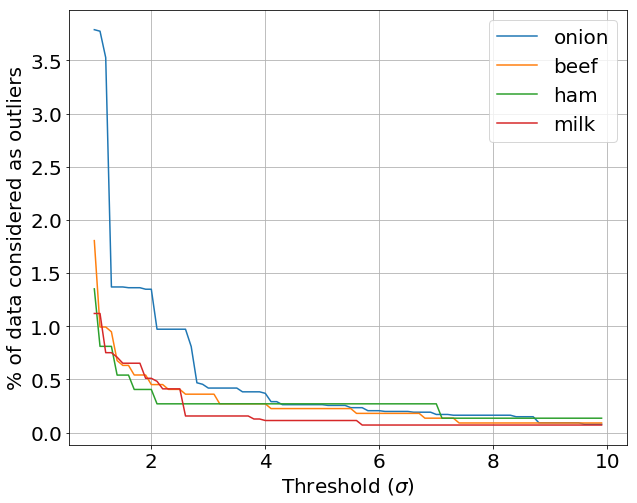

In [13]:
#plot variation of outliers for various ingredient
#  as a function of the threshold
plt.figure(figsize=(10,8))
std_list=np.arange(1,10,0.1)
testoutliers=['onion','beef','ham','milk']
for ingr in testoutliers:
    ratio_outliers=[]
    for i in std_list:
        axa=ingredients_frame[ingr].dropna()
        m=np.mean(axa)
        std=np.std(axa)
        ratio_outliers.append(sum(axa>m+i*std)/len(axa)*100)
        
    plt.plot(std_list,ratio_outliers,label=ingr)
plt.xlabel('Threshold ($\sigma$)',fontsize=20)
plt.ylabel('% of data considered as outliers',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.savefig('./fig/ouliers_reject_T.pdf')
plt.show()

99.8646209386


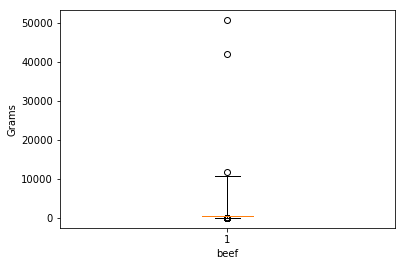

In [14]:
#plot boxplot of one ingred 
ingr='beef'
axa=ingredients_frame[ingr].dropna()
m=np.mean(axa)
std=np.std(axa)
ratio=sum(axa>m+7*std)/len(axa)
perc_to_put=100-ratio*100
print(perc_to_put)
plt.boxplot(ingredients_frame[ingr].dropna().tolist(),whis=[5,perc_to_put])
plt.xlabel(ingr)
plt.ylabel('Grams')
plt.show()

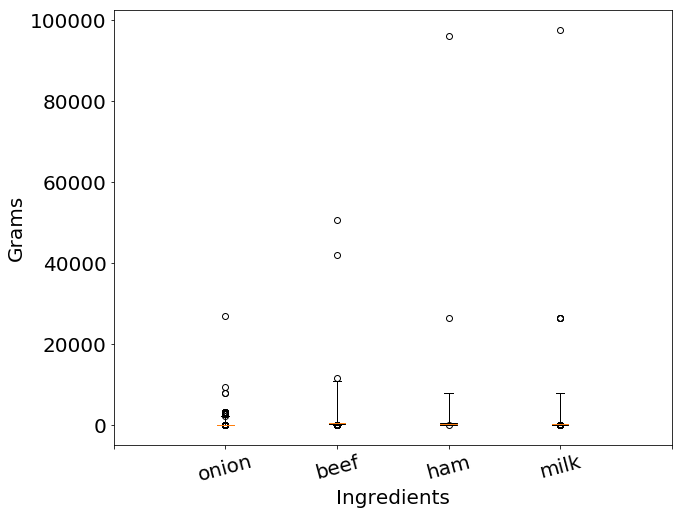

In [15]:
#enable multiple plot for all ingredient in list to plot
plt.figure(figsize=(10,8))
toplot=testoutliers
i=0
for ingr in toplot:
    axa=ingredients_frame[ingr].dropna()
    m=np.mean(axa)
    std=np.std(axa)
    ratio=sum(axa>m+7*std)/len(axa)
    perc_to_put=100-ratio*100
    plt.boxplot(ingredients_frame[ingr].dropna().tolist(),positions=range(2+i,3+i),whis=[5,perc_to_put],showfliers=True)
    i=i+1
plt.xlabel('Ingredients',fontsize=20)
plt.xticks(range(1,7),['']+testoutliers,rotation=15,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Grams',fontsize=20)
plt.savefig('./fig/ouliers_distrib.pdf')
plt.show()

In [16]:
to_delete=[]
for ingr in list(ingredients_frame):
    axa=ingredients_frame[ingr].dropna()
    m=np.mean(axa)
    std=np.std(axa)
    for ind, row in axa.iteritems():
        if (row>m+7*std) and (ind not in to_delete):
            to_delete.append(ind)
testframe=ingredients_frame.drop(to_delete).copy() 
#DROP the columns with only nan that could result from this operation
testframe=testframe.dropna(how='all',axis=1)
testframe.shape


(45601, 862)

In [17]:
print(testframe['hominy'].nlargest(n=15, keep='first'))
test_receipe(45135 ,False)

1631     3784.0
1625     1320.0
9813      990.0
366       948.0
10493     948.0
9539      906.0
36658     870.0
31859     812.0
7215      711.0
8994      711.0
21095     711.0
16758     660.0
17624     660.0
25884     660.0
27754     660.0
Name: hominy, dtype: float64
1412 ozs yellow hominy |8 ozs corn |2 tbsps lemon juice|1 clove clove garlic|12 tsp ground cumin|14 tsp cayenne


{'cayenne': '14 tsp',
 'corn': '8 10.0',
 'cumin': '12 tsp',
 'garlic': '1 10.0',
 'hominy': '1412 10.0',
 'lemon juice': '2 10.0'}

In [18]:
#Max quantities after outlier analysis
max_dic,max_index=fun_maxQ(testframe)
max_ordered=sorted((value,key) for (key,value) in max_dic.items())
#top 10 highest value
max_ordered[::-1][0:10]

[(26781.0, 'macaroon'),
 (18925.0, 'peanut oil'),
 (18120.0, 'venison'),
 (12684.0, 'cake'),
 (11200.0, 'broth'),
 (9966.0, 'paella'),
 (9750.0, 'grape juice'),
 (9060.0, 'fat'),
 (9060.0, 'beef'),
 (8202.6666671999992, 'cabbage')]

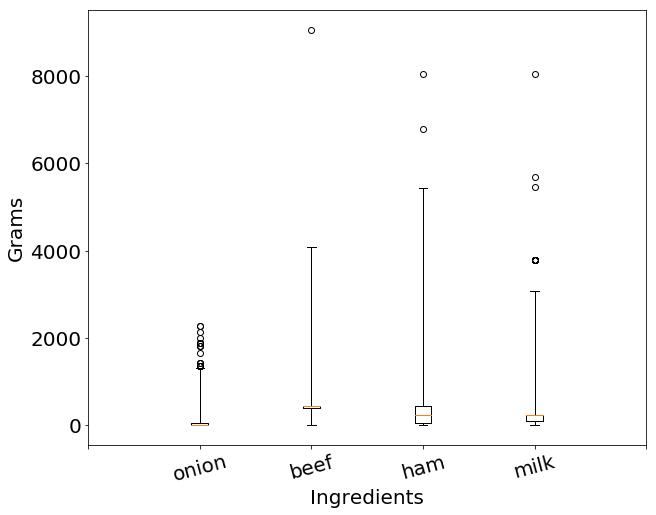

In [19]:
plt.figure(figsize=(10,8))
i=0
for ingr in testoutliers:
    axa=testframe[ingr].dropna()
    m=np.mean(axa)
    std=np.std(axa)
    ratio=sum(axa>m+9*std)/len(axa)
    perc_to_put=100-ratio*100
    plt.boxplot(testframe[ingr].dropna().tolist(),positions=range(2+i,3+i),whis=[0,perc_to_put],showfliers=True)
    i=i+1
    
# Creating boxplot of some ingredients to analye their distributions
plt.xlabel('Ingredients',fontsize=20)
plt.xticks(range(1,7),['']+testoutliers,rotation=15,fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Grams',fontsize=20)
plt.savefig('./fig/no_ouliers_distrib.pdf')
plt.show()

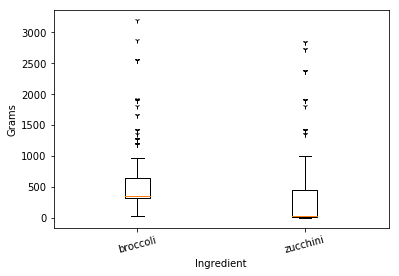

In [20]:
# Creating the box plot to quantify the amount of outliers and check at the values distribution
plt.boxplot([testframe['broccoli'].dropna().tolist(),testframe['zucchini'].dropna().tolist()],0,'1')
plt.xlabel('Ingredient')
plt.xticks(range(1,3),['broccoli','zucchini'],rotation=15)
plt.ylabel('Grams')
plt.show()

## Data Analysis

### Number of occurence for each ingredient in the whole dataframe

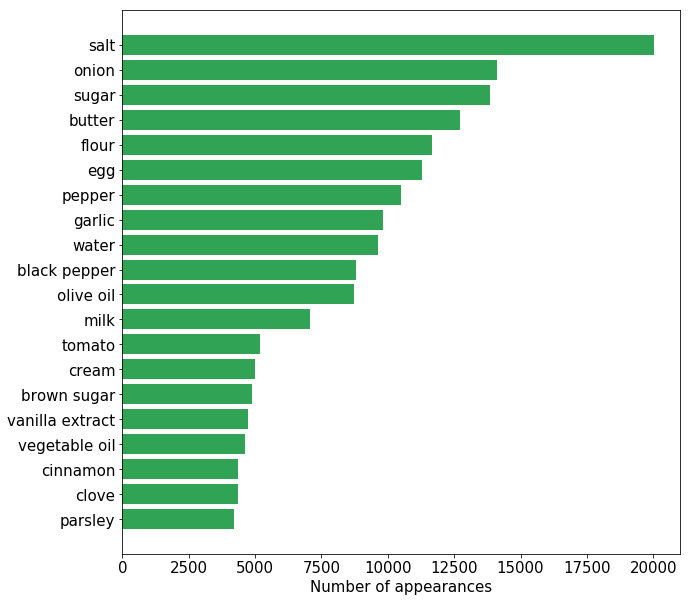

In [21]:
# ----- Sort the ingredients by occurrence ----- #
occu=sorted((value,key) for (key,value) in ingred_used.items())
occu[::-1]

# Plot of the number of occurences of each ingredient.
ing_occ = pd.DataFrame(occu[::-1]).head(20)
ing_occ = ing_occ.sort_values(0,ascending=True)
people = ing_occ[1].values
score = ing_occ[0].values
x_pos = np.arange(len(people))
plt.figure(figsize=((10,10)))
plt.barh(x_pos, score,align='center',color='#31a354')
plt.xlabel('Number of appearances',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(x_pos,people, fontsize =15)
plt.show()

### Occurrence per category

In [22]:
#import  the csv contain the category of each ingredient
ingredients_categories = pd.read_csv('Webscrapping by little people - Feuille 1.csv',sep=',')


categorie_dic = ingredients_categories.set_index('Ingredient')['Category'].to_dict()


occu=sorted((value,key) for (key,value) in ingred_used.items())
x = list(map(lambda x : (x[0],categorie_dic[x[1]]),occu[::-1]))
cat = [[],[],[],[],[],[],[]]
for i in x:
    cat[i[1]].append(i[0])

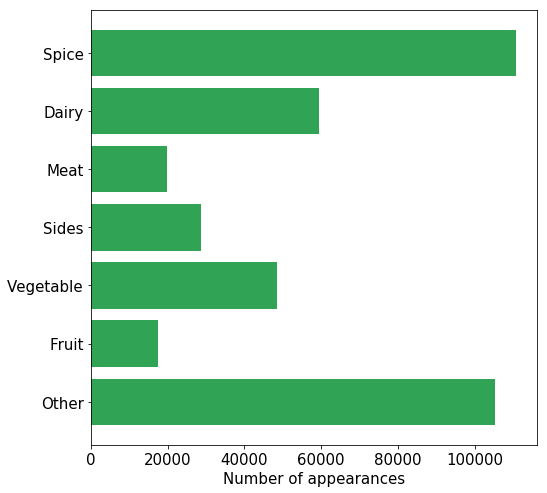

In [23]:
# Script for plotting the numbber of ingredients per category
people = ['Other','Fruit','Vegetable','Sides','Meat','Dairy','Spice']
score = list(map(lambda x : np.sum(x),cat))
x_pos = np.arange(len(people))
plt.figure(figsize=((8,8)))
plt.barh(x_pos, score,align='center',color='#31a354')
plt.xlabel('Number of appearances',fontsize =15)
plt.xticks(fontsize =15)
plt.yticks(x_pos,people, fontsize =15)
plt.show()

### Show the distribution of number of ingredients per recipe

In [24]:
a = ingredients_frame.count(axis=1).value_counts(sort =False)
a = a.sort_index()


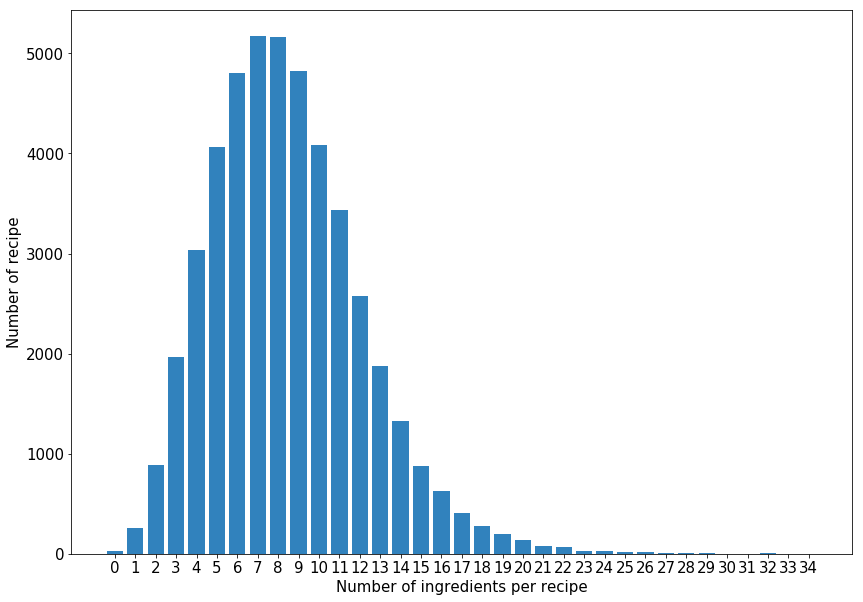

In [25]:
# Script for ploting the number of ingredients per recipe
people = a.index
score = a.values
x_pos = np.arange(len(people))
plt.figure(figsize=((14,10)))
plt.bar(x_pos, score,align='center',color='#3182bd')
plt.ylabel('Number of recipe',fontsize =15)
plt.xlabel('Number of ingredients per recipe',fontsize =15)
plt.yticks( fontsize =15)
plt.xticks(x_pos,people, fontsize =15)
plt.show()

### Compute the number of vegan and vegetarian recipes

In [26]:
a = list(map(lambda x : ingredients_frame.loc[x].dropna(),range(ingredients_frame.shape[0])))

In [27]:
# computing the number of recipes containing meat or fish
meat = 0

for i in a:
    for j in i.index:
        if categorie_dic[j] == 4:
            meat +=1
            break
# calculating the ratio of vegetarian recipes            
print('Percentage of vegetarian recipe: ',round((ingredients_frame.shape[0]- meat)*100/ingredients_frame.shape[0],1),'%')

Percentage of vegetarian recipe:  64.3 %


In [28]:
# computing the number of recipes containing meat or fish
meat_dairy = 0

for i in a:
    for j in i.index:
        if categorie_dic[j] == 4:
            meat_dairy +=1
            break
        if categorie_dic[j] == 5:
            meat_dairy +=1
            break
# calculating the ratio of vegan recipes                
print('Percentage of vegan recipe: ',round((ingredients_frame.shape[0]- meat_dairy)*100/ingredients_frame.shape[0], 1),'%')

Percentage of vegan recipe:  19.7 %


## 3/ Co-occurences and Covariance

### Co-occurences



In [29]:
# ----- Using K-NN to find the the association between ingredient ----- #
newdf = testframe.notnull().astype('int')
coocc = newdf.T.dot(newdf)
display(coocc.head(5))

,acidulated water,acorn squash,agave,ale,aleppo pepper,alfalfa sprout,allspice,almond,almond extract,almond milk,...,worcestershire sauce,wrap,yam,yeast,yellow lentil,yoghurt,yogurt,yuzu,zest,zucchini
acidulated water,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acorn squash,0,64,0,0,0,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,0
agave,0,0,49,0,0,0,1,6,2,1,...,1,0,0,2,0,0,1,0,0,2
ale,0,0,0,17,0,0,0,2,0,0,...,3,0,0,0,0,0,0,0,1,0
aleppo pepper,0,0,0,0,4,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


#### Similarity and best association of ingredients
Using the co-occurence matrice we compute with the k- Nearest Neighbourg Regression, the proximity between ingredients and end up with a combination of ingredients which would be likely associated to a specific ingredient.

For instance, for apple chutney we find ingredients that is great when they are combined.

In [30]:
# Finding the proximity of ingredients using k-nearest neighbors
r=0.4
number_neighbors_toshow=20
neigh = NearestNeighbors(number_neighbors_toshow,r)
neigh.fit(coocc.values)

nn = neigh.kneighbors(coocc.values, return_distance=False)
Nn_pd = pd.DataFrame(nn)
dict_nn = dict(zip(range(len(testframe.columns)),list(testframe.columns)))
Nn_pd.replace(dict_nn, inplace=True)
Nn_pd.rename(index=dict_nn,inplace=True)
Nn_pd.loc['apple chutney'][1:]

1             lamb rack
2         flaked almond
3           ginger beer
4      japanese pumpkin
5                 nacho
6            herbal tea
7         clotted cream
8            soya flour
9             milkshake
10             bechamel
11               borage
12        confectionery
13    chocolate biscuit
14          filo pastry
15            soya bean
16                  eel
17    lancashire cheese
18            pecan nut
19           co lettuce
Name: apple chutney, dtype: object

### Covariance

C_ij is the covariance between the i th and j th ingredients.

Covariance is just unscaled correlation.  
If a number at a certain position in the covariance matrix is large, then the variable that corresponds to that row and the variable that corresponds to that column change with one another. When one goes up, the other goes up. When one goes down, the other goes down. 

It will help us to know how to adjust quantity between ingredients.

As we implemented 'u' unit for the ingredient that had no unit, therefore could not be directly converted to gram, we cannot numericaly analyse our dataframe. For the time being for replace u by the average of other apparition of that ingredient. We are currently, working on a method to scrap info about average weight of diverse ingredients. (cf web scrapping) 

In [31]:
ratio_u_ingred={}
test_ingredients_frame=ingredients_frame.copy()
for ingred in list(ingredients_frame):
    mean = ingredients_frame[ingred].apply(pd.to_numeric, errors='coerce').dropna(axis=0, how='any').mean()
    if math.isnan(mean):
        mean=1
    test_ingredients_frame[ingred][ingredients_frame[ingred].astype(str).str.contains('u')]=mean
    #calculate the ratio of unit in each ingredient:
    ratio_u_ingred[ingred]=\
    sum(ingredients_frame[ingred].dropna(axis=0, how='any').astype(str).str.contains('u'))/len(ingredients_frame[ingred].dropna(axis=0, how='any').astype(str).str.contains('u'))

ingr_matrix=test_ingredients_frame.fillna(0).values.T
covar=np.cov(ingr_matrix)

## 4/ Linear Regression
With the linear regression on the nutrients information from the data, we will be able to compute an approximation of nutrient value for each ingredient so that we can approximate the nutrient value for the recipes which the value was missing in the dataset

In [32]:
#function that take a type of nutriment on input and output 2 dataframe 
# on which we will apply machine learning 
def predict_w(nutriment):
    print(nutriment)
    testframe['tot']= ingr_dataframe[nutriment]
    test_ingredients_frame=testframe.fillna(0).copy()
    test_ingredients_frame.replace('?',np.nan,inplace=True)
    test_ingredients_frame.dropna(axis=0,how='any',inplace=True)
    Train_set = test_ingredients_frame
    X = Train_set.drop(['tot'],axis=1)
    Y = Train_set['tot'] 
    print(X.shape)
    X_tot=X
    Y_tot=Y
    return X_tot,Y_tot

#------after lookin various possibility we chose the model ---------------
#        for each nutriment that predicted them the best
#   in general the MSLE gave lowest error and is not too sensible to outliers.
#here we use the lowest regularizer 
def perceptron_carb():#and protein
    model = Sequential()                                               
    model.add(Dense(1,input_dim=ingred_nb, kernel_initializer= 'orthogonal' ,\
                    kernel_constraint=nonneg(),kernel_regularizer=regularizers.l2(0.01),\
                    activation= 'linear',use_bias=False ))
    model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae']) #logarithmic loss function
    return model

#highest reguralizer because the model had a tendency to put too big weight
def perceptron_fat():
    model = Sequential()                                               
    model.add(Dense(1,input_dim=ingred_nb, kernel_initializer= 'orthogonal' ,\
                    kernel_constraint=nonneg(),kernel_regularizer=regularizers.l2(1),\
                    activation= 'linear',use_bias=False ))
    model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae']) #logarithmic loss function
    return model

#percpetron for cholesterol
def perceptron_chol():
    model = Sequential()                                               
    model.add(Dense(1,input_dim=ingred_nb, kernel_initializer= 'orthogonal' ,\
                    kernel_constraint=nonneg(),kernel_regularizer=regularizers.l2(0.1),\
                    activation= 'linear',use_bias=False ))
    model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae']) #logarithmic loss function
    return model

#2 layer neural net that predicted quite well for kcal. 
def predict_kcal():
    model = Sequential()                                               
    model.add(Dense(60,input_dim=ingred_nb, kernel_initializer= 'orthogonal' ,\
                    kernel_regularizer=regularizers.l2(0.1),\
                    activation= 'relu',use_bias=False ))
    model.add(Dense(1, use_bias=False,kernel_initializer= 'orthogonal' , activation= 'linear' ))       #pour multivariate classi augmenter nbr d'output à Nobjet
    model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mae']) #logarithmic loss function
    return model 

def print_result(df,index):
    display(df.iloc[index].replace(0,np.nan).dropna())
#kernel_regularizer=regularizers.l2(0.1)
#other losses:'mean_squared_error' , 'mean_absolute_error','mean_squared_logarithmic_error

In [33]:
#creation of the dictionnary: 
for nutriment in ['kcal_carb','kcal_protein','mg_cholesterol','kcal_fat']:
    X,Y=predict_w(nutriment)
    X_tot=X.values
    Y_tot=Y.values
    start_time = time.time()
    [receipe_nb,ingred_nb]=X_tot.shape

    if nutriment=='kcal_carb' or nutriment=='kcal_protein':
        model=perceptron_carb()
    elif nutriment=='mg_cholesterol':
        model=perceptron_chol()
    elif nutriment=='kcal_fat':
        model=perceptron_fat()
        
    else: model=predict_kcal()
    
    model.fit(X_tot,Y_tot, epochs=40, batch_size=100,verbose=0)
    
    w=model.get_weights()
    type_dic={}
    for i,ingr in enumerate(list(X)):
        type_dic[ingr]=float(w[0][i])
    with open(nutriment+'.json', 'w') as fp:
        json.dump(type_dic, fp)
    
    
#for 'kcal_total' can't predict good linear relation but a Neural net can predict better

kcal_carb
(33798, 862)
kcal_protein
(33791, 862)
mg_cholesterol
(32808, 862)
kcal_fat
(33776, 862)


In [34]:
#predict  for a specific case
#or assess the quality of a model
X,Y=predict_w('kcal_carb')
X_tot=X.values
Y_tot=Y.values
X_train=X_tot[:30000]
Y_train = Y_tot[:30000]
start_time = time.time()
model=perceptron_carb()
model.fit(X_train,Y_train, epochs=2, batch_size=100,verbose=1)
X_test = X_tot[30000:]
Y_test = Y_tot[30000:]
scores=model.evaluate(X_test,Y_test,batch_size=1)
print("\n %s: %.2f" % (model.metrics_names[1], scores[1]*100))
print("--- %s seconds ---" % (time.time() - start_time))

Y_predict=model.predict(X_test)
print(Y_predict[0:3])
print(Y_test[0:3])


print('\n The prediction  might have a big fluctuation but they are reasonable value for the recipes')

kcal_carb
(33798, 862)
Epoch 1/2
30000/30000 [==============================] - 1s 46us/step - loss: 2.0846 - mean_absolute_error: 101.2929
Epoch 2/2
3798/3798 [==============================] - 3s 691us/step

 mean_absolute_error: 8788.56
--- 5.541848182678223 seconds ---
[[  38.68202972]
 [ 106.00741577]
 [  16.67329597]]
['8.8' '165.2' '22.4']

 The prediction  might have a big fluctuation but they are reasonable value for the recipes


In [35]:
#or just to load the dics:
nutriment_dic={}
for type_ in ['kcal_carb','kcal_protein','mg_cholesterol','kcal_fat']:
    with open(type_+'.json', 'r') as fp:
        nutriment_dic[type_] = json.load(fp)
        
print("To illustrate our result let's see what nutritional values we have for an apple: \n")
comparaison=pd.DataFrame(index=['kcal_carb','kcal_protein','mg_cholesterol','kcal_fat']\
                        ,columns=['Approximate Tabled values for 100 g','Fit'])
comparaison['Approximate Tabled values for 100 g']['kcal_carb']=14
comparaison['Approximate Tabled values for 100 g']['kcal_protein']=0.3
comparaison['Approximate Tabled values for 100 g']['mg_cholesterol']=0
comparaison['Approximate Tabled values for 100 g']['kcal_fat']=0.2

test = 'apple'
comparaison['Fit']['kcal_carb']=nutriment_dic['kcal_carb'][test]*100
comparaison['Fit']['kcal_protein']=nutriment_dic['kcal_protein'][test]*100
comparaison['Fit']['mg_cholesterol']=nutriment_dic['mg_cholesterol'][test]*100
comparaison['Fit']['kcal_fat']=nutriment_dic['kcal_fat'][test]*100

display(comparaison)

To illustrate our result let's see what nutritional values we have for an apple: 



,Approximate Tabled values for 100 g,Fit
kcal_carb,14,13.8185
kcal_protein,0.3,0.106224
mg_cholesterol,0,0.00464185
kcal_fat,0.2,1.30051


## 5/ Compute new special recipes

From the result of the KNN Regression, we could extract the list of ingredient with high interaction to a specific ingredient. Then we create recipe from that we a random number of ingredient per categorie subject to Nutrition Constraints.

In [36]:
# Load the categorie associated to each ingredient and construct a dictionary
ingredients_categories = pd.read_csv('Webscrapping by little people - Feuille 1.csv',sep=',')
categorie_dic = ingredients_categories.set_index('Ingredient')['Category'].to_dict()

# List of ingredient for each recipe, in order to extract the recipe with the specific ingredient asked
list_to_check_ingredient = list(map(lambda x : ingredients_frame.loc[x].dropna(),range(ingredients_frame.shape[0])))

In [37]:
# Function to define the quantity for each ingredient in the recipe according to the quantity entered by the user
def ingredient_quantities(ingridient_list,mean_ingridient,quantity):

    main = ingridient_list[0]
    quantity_ratio = []
    for i in ingridient_list:
        quantity_ratio.append(round((mean_ingridient[i]*quantity)/mean_ingridient[main]))
    return quantity_ratio

# Create the recipe
def special_recipe(Ingredient ,Quantity, Vegan = False,Vegetarian=False,Healthy=False):
# Create a counter in order to not have too much ingredient from the same category
    count_max = [randint(1,2),randint(1,2),randint(1,2),randint(1,2),1,randint(1,2),randint(1,2)]
    
# Condition to respect constraint
    if (Vegan == True):
        elem = [5,4]
        count_max[4]=0
        count_max[5]=0
        if int(categorie_dic[Ingredient]) in elem:
            return('You want to eat vegan with a non vegan ingredient')
    if (Vegetarian == True):
        count_max[4]=0
        if int(categorie_dic[Ingredient]) == 4:
            return('You want to eat vegatarian with a meat as ingredient')
        
    """if (Healthy == True):
        elem = [5,0,3]              
        count_max[5]=0
        count_max[0]=0
        count_max[3]=0
        if int(categorie_dic[Ingredient]) in elem:
            return("It's impossible to create healthy recipe with this ingredient, Sorry")"""

# Create recipe by picking a ingredient in the list from KNN regression
    count_gen =np.zeros(7)
    Recipe = []
    count_gen[int(categorie_dic[Ingredient])] += int(1)
    Recipe.append(Ingredient)
    ing_layer1 = Nn_pd.loc[Ingredient][1:].values.tolist()
    dic_ing_layer1 = list(map(lambda x: int(categorie_dic[x]),ing_layer1))
    i = 0
    while not (np.array_equal(count_gen,count_max)): # While the counter is not complete, the algorithm tries to complete the recipe
        
    # This part remove all the ingredient from the list which their counter is full
        if (count_gen[0] == count_max[0]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==0]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if (count_gen[1] == count_max[1]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==1]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if (count_gen[2] == count_max[2]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==2]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if (count_gen[3] == count_max[3]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==3]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if (count_gen[4] == count_max[4]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==4]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if (count_gen[5] == count_max[5]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==5]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if (count_gen[6] == count_max[6]):
            drop = [i for i,x in enumerate(dic_ing_layer1) if x==6]
            ing_layer1 = [i for j, i in enumerate(ing_layer1) if j not in drop]
            dic_ing_layer1 = [i for j, i in enumerate(dic_ing_layer1) if j not in drop]
        if not (ing_layer1):
            break
        
        x = random.choice(ing_layer1) 
        if x in Recipe :
            x = random.choice(ing_layer1) 
        if (Healthy == True):
            while (nutriment_dic['kcal_fat'][x]*100 > 1):
                x = random.choice(ing_layer1)
        Recipe.append(x)
        count_gen[int(categorie_dic[x])] += int(1)
        ing_layer1 = ing_layer1 + Nn_pd.loc[x][1:].values.tolist()
        ing_layer1.remove(x)
        dic_ing_layer1 = list(map(lambda x: categorie_dic[x],ing_layer1))
    print('\033[4mList of ingredients:\033[0m ',*Recipe, '\n', sep= '|')
    
# Nutrients informations for the special recipe
    Kcal_carb = np.sum(list(map(lambda x : nutriment_dic['kcal_carb'][x]*100,Recipe)))
    Kcal_prot = np.sum(list(map(lambda x : nutriment_dic['kcal_protein'][x]*100,Recipe)))
    Kcal_fat = np.sum(list(map(lambda x : nutriment_dic['kcal_fat'][x]*100,Recipe)))
    cholest = np.sum(list(map(lambda x : nutriment_dic['mg_cholesterol'][x]*100,Recipe)))
    
# Return the quantity for each ingredient selected in the recipe
    mean_ingridient = testframe.mean()
    quantity = ingredient_quantities(Recipe,mean_ingridient,float(Quantity))

# This Part create the sentence where the ingredient appears with their quantity and their preparation techniques
    recip_dic = list(map(lambda x: categorie_dic[x],Recipe))
    
    drop = [i for i,x in enumerate(recip_dic) if x==0]
    quantity_other = [i for j, i in enumerate(quantity) if j in drop]
    Other = [i for j, i in enumerate(Recipe) if j in drop]
    drop = [i for i,x in enumerate(recip_dic) if x==1]
    Fruit = [i for j, i in enumerate(Recipe) if j in drop]
    quantity_fruit = [i for j, i in enumerate(quantity) if j in drop]
    drop = [i for i,x in enumerate(recip_dic) if x==2]
    Vegetable = [i for j, i in enumerate(Recipe) if j in drop]
    quantity_veg = [i for j, i in enumerate(quantity) if j in drop]
    drop = [i for i,x in enumerate(recip_dic) if x==3]
    Sides = [i for j, i in enumerate(Recipe) if j in drop]
    quantity_sides = [i for j, i in enumerate(quantity) if j in drop]
    drop = [i for i,x in enumerate(recip_dic) if x==4]
    quantity_meat = [i for j, i in enumerate(quantity) if j in drop]
    Meat = [i for j, i in enumerate(Recipe) if j in drop]
    drop = [i for i,x in enumerate(recip_dic) if x==5]
    Dairy = [i for j, i in enumerate(Recipe) if j in drop]
    quantity_dairy = [i for j, i in enumerate(quantity) if j in drop]
    drop = [i for i,x in enumerate(recip_dic) if x==6]
    Spice = [i for j, i in enumerate(Recipe) if j in drop]
    quantity_spice = [i for j, i in enumerate(quantity) if j in drop]
    
    def select_tec(name):
        if (len(dict_tec[name]) >0):
            s_tec = random.choice(dict_tec[name])
            if(s_tec == 'removed'):
                s_tec = ''
            if(s_tec == 'divided'):
                s_tec = ''
        else:
            s_tec =''
        return(s_tec)
    
    veg_fruit_text = list(map( lambda x : ' grams '.join(x[0]),list(map(lambda x : [[str(x[0])]+[x[1]]],[[m,n] for m,n in zip((quantity_veg+quantity_fruit),(list(map(lambda x : select_tec(x)+' '+x,Vegetable+Fruit))))]))))
    spices_text = list(map( lambda x : ' grams '.join(x[0]),list(map(lambda x : [[str(x[0])]+[x[1]]],[[m,n] for m,n in zip((quantity_spice),(list(map(lambda x : select_tec(x)+' '+x,Spice))))]))))
    sides_text = list(map( lambda x : ' grams '.join(x[0]),list(map(lambda x : [[str(x[0])]+[x[1]]],[[m,n] for m,n in zip((quantity_sides),(list(map(lambda x : select_tec(x)+' '+x,Sides))))]))))
    meat_text = list(map( lambda x : ' grams '.join(x[0]),list(map(lambda x : [[str(x[0])]+[x[1]]],[[m,n] for m,n in zip((quantity_meat),(list(map(lambda x : select_tec(x)+' '+x,Meat))))]))))
    other_dairy_text = list(map( lambda x : ' grams '.join(x[0]),list(map(lambda x : [[str(x[0])]+[x[1]]],[[m,n] for m,n in zip((quantity_other+quantity_dairy),(list(map(lambda x : select_tec(x)+' '+x,Other+Dairy))))]))))
    

# Part to return existing recipes in the dataset containing the ingredient chosen by the user
    
    recipe_with = []
    y = []
    for num,i in enumerate(list_to_check_ingredient):
        for j in i.index:
            if j == Ingredient:
                recipe_with.append(num)
                break
                
    if len(recipe_with) >1:
        y = np.random.choice(recipe_with,size = 4, replace=False)            
    else:
        y = recipe_with

    if (Vegan == True):
        print(emoji.emojize('- :tomato: Cook the '),*veg_fruit_text,'\n\n- And season all with the following spices',*spices_text,emoji.emojize(':honey_pot: to taste. \n\n' '- Eat with'),*sides_text,emoji.emojize('as sides :spaghetti: to the meal.'), emoji.emojize('\n\n- To enhance this meal do not hesitate twice to add :rice_cracker:'),*other_dairy_text,sep= '| ') 
    elif Vegetarian == True:
        print(emoji.emojize('- :meat_on_bone: Cook the '),*meat_text,emoji.emojize('\n\n- :tomato: Accompanied with the '),*veg_fruit_text,'\n\n- And season all with the following spices',*spices_text,emoji.emojize(':honey_pot: to taste. \n\n' '- Eat with'),*sides_text,emoji.emojize('as sides :spaghetti: to the meal.'), emoji.emojize('\n\n- To enhance this meal do not hesitate twice to add :rice_cracker:'),*other_dairy_text,sep= '| ') 

    else:
        print(emoji.emojize('- :meat_on_bone: Cook the '),*meat_text,emoji.emojize('\n\n- :tomato: Accompanied with the '),*veg_fruit_text,'\n\n- And season all with the following spices',*spices_text,emoji.emojize(':honey_pot: to taste. \n\n' '- Eat with'),*sides_text,emoji.emojize('as sides :spaghetti: to the meal.'), emoji.emojize('\n\n- To enhance this meal do not hesitate twice to add :rice_cracker:'),*other_dairy_text,sep= '| ') 
    
    print("\n \033[4mNUTRITION INFO:\033[0m \n",'Per 100g')
    print('Cholesterol : ',round(cholest,1),'mg')
    print('Total Carbohydrate : ',round(Kcal_carb,1), 'g')
    print('Protein : ',round(Kcal_prot,1), 'g')
    print('Total Fat : ',round(Kcal_fat,1), 'g')
    print('Total Calorie : ',round(Kcal_carb*4+Kcal_prot*4+Kcal_fat*9,1))
    
    print_existing_site = list(map(lambda x : x,[m+'\n' +n for m,n in zip(ingr_dataframe['title'][y].values,ingr_dataframe['url'][y].values)]))
    print('\n\n \033[4mExisting recipe(s):\033[0m', *print_existing_site,sep= '\n ')
    
   

### Interactive interface creating and print the recipe

In [38]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(special_recipe, Ingredient=testframe.columns.values,Quantity ='200');